
# Segmenting and Clustering Neighborhoods in Toronto


## Explore and cluster the neighborhoods in Toronto


1.  Import dataframe gathered from my other notebook:



In [1]:
# First set IPython kernel such that we see all the outputs:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np

df = pd.read_csv('/home/francis/Dropbox/commands/ibm/9-applied-data-science-capstone/toronto_neighbourhoods.csv', index_col=0)

2. Select boroughs that contain the word "Toronto":

In [2]:
torontodf = df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
torontodf.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.671024,-79.296712
1,M4K,East Toronto,"The Danforth West, Riverdale",43.686433,-79.300356
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.671024,-79.296712
3,M4M,East Toronto,Studio District,43.649288,-79.376790
4,M4N,Central Toronto,Lawrence Park,43.729199,-79.403253


### Getting the nearby venues of neighbourhoods (postal codes)

3. Import my Foursquare credentials:

In [3]:
import json

with open('foursquare_credentials.json') as f:
    data = json.load(f)
    CLIENT_ID = data['username']
    CLIENT_SECRET = data['password']


4. Create function to get nearby venues of each neighbourhood:

In [4]:
# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# library to handle requests
import requests

# Foursquare API version
#VERSION = '20180605'
VERSION = '20191229'
# limit of number of venues returned by Foursquare API
LIMIT = 100

# defining function to retrieve nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

5. Create new dataframe with venues by running the function above:

In [5]:
venuesdf = getNearbyVenues(names=torontodf['PostalCode'],
                                   latitudes=torontodf['Latitude'],
                                   longitudes=torontodf['Longitude']
                                  )

M4E
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6G
M6H
M6J
M6K
M6P
M6R
M6S
M7Y
M9A


In [6]:
print(venuesdf.shape)
venuesdf.head(3)

(2231, 7)


,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.671024,-79.296712,Kew Gardens,43.669038,-79.298538,Park
1,M4E,43.671024,-79.296712,Mastermind Toys,43.671453,-79.293971,Toy / Game Store
2,M4E,43.671024,-79.296712,The Ten Spot,43.670340,-79.299363,Nail Salon


Check how many venues were returned for each postal code:

In [7]:
venuesdf.groupby('PostalCode').count().head(5)

,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
M4E,50,50,50,50,50,50
M4K,30,30,30,30,30,30
M4L,50,50,50,50,50,50
M4M,100,100,100,100,100,100
M4N,52,52,52,52,52,52


### One hot encoding before the clustering analysis

6. One hot encoding:

In [8]:
# one hot encoding
onehot = pd.get_dummies(venuesdf[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe and move it to the first column
onehot['PostalCode'] = venuesdf['PostalCode'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head(3)

,PostalCode,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M4E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


7. Group rows by postal code and by taking the mean of the frequency of occurrence of each category:

In [9]:
# Show only last result of cells from hereon
InteractiveShell.ast_node_interactivity = "last"

groupeddf = onehot.groupby('PostalCode').mean().reset_index()
groupeddf.head()

,PostalCode,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Train Station,Tree,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M4E,0.0,0.00,0.0,0.00,0.02,0.000000,0.0,0.0,0.020000,...,0.000000,0.02,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,M4K,0.0,0.00,0.0,0.00,0.00,0.000000,0.0,0.0,0.033333,...,0.033333,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
2,M4L,0.0,0.00,0.0,0.00,0.02,0.000000,0.0,0.0,0.020000,...,0.000000,0.02,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,M4M,0.0,0.03,0.0,0.02,0.00,0.010000,0.0,0.0,0.020000,...,0.000000,0.00,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.0
4,M4N,0.0,0.00,0.0,0.00,0.00,0.038462,0.0,0.0,0.019231,...,0.000000,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0


8. Create dataframe with top 10 venues:

In [10]:
# Write first a function to sort the venues in descending order:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Choose top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} most common venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th most common venue'.format(ind+1))

# create a new dataframe
postalcodes_venues_sorted = pd.DataFrame(columns=columns)
postalcodes_venues_sorted['PostalCode'] = groupeddf['PostalCode']

for ind in np.arange(groupeddf.shape[0]):
    postalcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(groupeddf.iloc[ind, :], num_top_venues)

postalcodes_venues_sorted.head()

,PostalCode,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,M4E,Beach,Pub,Thai Restaurant,Japanese Restaurant,Breakfast Spot,Coffee Shop,Park,Tea Room,Pizza Place,Bar
1,M4K,Coffee Shop,Bus Line,Grocery Store,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Restaurant,Spa,Market,Dance Studio
2,M4L,Beach,Pub,Thai Restaurant,Japanese Restaurant,Breakfast Spot,Coffee Shop,Park,Tea Room,Pizza Place,Bar
3,M4M,Café,Coffee Shop,Restaurant,Hotel,Bakery,Japanese Restaurant,Seafood Restaurant,American Restaurant,Beer Bar,Gastropub
4,M4N,Italian Restaurant,Sushi Restaurant,Bakery,Coffee Shop,Pizza Place,Pub,Ice Cream Shop,Asian Restaurant,Burger Joint,Spa


### Cluster postal codes

9. k-means to cluster the neighbourhoods. Plot SSE of different values of cluster numbers to find ideal number of clusters:

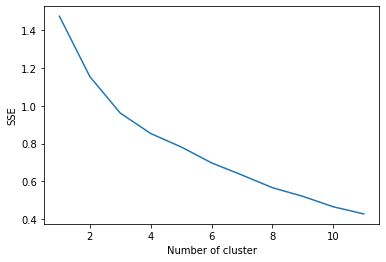

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

groupeddf_clustering = groupeddf.drop('PostalCode', 1)

sse = {}
for kclusters in range(1, 12):
    kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(groupeddf_clustering)
    data["clusters"] = kmeans.labels_
    sse[kclusters] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

Looking at the graph, 3 or 4 clusters seem to represent a good elbow (inflection) point. After some trials, we decided to choose 3 clusters.

10. k-means to cluster the neighborhood into 3 clusters.

In [12]:
# set number of clusters
kclusters = 3

groupeddf_clustering = groupeddf.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(groupeddf_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1], dtype=int32)

11. Create new dataframe that includes the cluster as well as the top 10 venues for each postal code:

In [13]:
# add clustering labels
postalcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

finaldf = torontodf

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
finaldf = finaldf.join(postalcodes_venues_sorted.set_index('PostalCode'), on='PostalCode')

finaldf.head(3) # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,M4E,East Toronto,The Beaches,43.671024,-79.296712,1,Beach,Pub,Thai Restaurant,Japanese Restaurant,Breakfast Spot,Coffee Shop,Park,Tea Room,Pizza Place,Bar
1,M4K,East Toronto,"The Danforth West, Riverdale",43.686433,-79.300356,1,Coffee Shop,Bus Line,Grocery Store,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Restaurant,Spa,Market,Dance Studio
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.671024,-79.296712,1,Beach,Pub,Thai Restaurant,Japanese Restaurant,Breakfast Spot,Coffee Shop,Park,Tea Room,Pizza Place,Bar


12. Finally, visualise clusters:

In [14]:
import folium
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# get coordinates of Toronto
address = 'Toronto city centre, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width=800, height=400)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finaldf['Latitude'], finaldf['Longitude'], finaldf['PostalCode'], finaldf['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysing clusters

- 1st cluster

In [15]:
finaldf.loc[finaldf['Cluster Labels'] == 0, finaldf.columns[[1] + list(range(5, finaldf.shape[1]))]]

,Borough,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
8,Central Toronto,0,Playground,Convenience Store,Restaurant,Gym,Tennis Court,Filipino Restaurant,Festival,Fast Food Restaurant,Eastern European Restaurant,Falafel Restaurant
34,West Toronto,0,Convenience Store,Pizza Place,Pool,Pet Store,Café,Sporting Goods Shop,Tennis Court,Pub,Mexican Restaurant,Gym


- 2nd cluster

In [16]:
finaldf.loc[finaldf['Cluster Labels'] == 1, finaldf.columns[[1] + list(range(5, finaldf.shape[1]))]]

,Borough,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
0,East Toronto,1,Beach,Pub,Thai Restaurant,Japanese Restaurant,Breakfast Spot,Coffee Shop,Park,Tea Room,Pizza Place,Bar
1,East Toronto,1,Coffee Shop,Bus Line,Grocery Store,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Restaurant,Spa,Market,Dance Studio
2,East Toronto,1,Beach,Pub,Thai Restaurant,Japanese Restaurant,Breakfast Spot,Coffee Shop,Park,Tea Room,Pizza Place,Bar
3,East Toronto,1,Café,Coffee Shop,Restaurant,Hotel,Bakery,Japanese Restaurant,Seafood Restaurant,American Restaurant,Beer Bar,Gastropub
4,Central Toronto,1,Italian Restaurant,Sushi Restaurant,Bakery,Coffee Shop,Pizza Place,Pub,Ice Cream Shop,Asian Restaurant,Burger Joint,Spa
5,Central Toronto,1,Dessert Shop,Sandwich Place,Coffee Shop,Café,Sushi Restaurant,Gym,Pizza Place,Italian Restaurant,Diner,Brewery
6,Central Toronto,1,Bar,Vegetarian / Vegan Restaurant,Restaurant,Coffee Shop,Asian Restaurant,Vietnamese Restaurant,New American Restaurant,Pizza Place,Men's Store,Café
7,Central Toronto,1,Dessert Shop,Sandwich Place,Coffee Shop,Café,Sushi Restaurant,Gym,Pizza Place,Italian Restaurant,Diner,Brewery
9,Central Toronto,1,Coffee Shop,Italian Restaurant,Sushi Restaurant,Pharmacy,Pizza Place,Gym,Grocery Store,Café,Sandwich Place,Bagel Shop
10,Downtown Toronto,1,Coffee Shop,Burger Joint,Clothing Store,Middle Eastern Restaurant,Ramen Restaurant,Italian Restaurant,Tea Room,Diner,Bubble Tea Shop,Sushi Restaurant


- 3rd cluster

In [17]:
finaldf.loc[finaldf['Cluster Labels'] == 2, finaldf.columns[[1] + list(range(5, finaldf.shape[1]))]]

,Borough,Cluster Labels,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,6th most common venue,7th most common venue,8th most common venue,9th most common venue,10th most common venue
23,Central Toronto,2,Playground,Park,Bank,Electronics Store,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Filipino Restaurant,Festival


- 4th cluster

In [18]:
#finaldf.loc[finaldf['Cluster Labels'] == 3, finaldf.columns[[1] + list(range(5, finaldf.shape[1]))]]

The first cluster groups the neighbourhoods predominantly containing convenience stores. The second cluster is composed mostly of restaurants and cafés. The third cluster contains playgrounds and parks mostly.